# Investment Strategy

In [11]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.15)
import warnings; warnings.filterwarnings('ignore')
from IPython.display import Markdown, display
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, RidgeCV, LassoCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.3f}'.format
plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
#LOAD LOANSTATS
directory = '../../data/'
ls = pd.read_hdf(directory + 'ls_CLEAN.h5', 'ls_CLEAN')
ls.sort_index(axis=1, inplace=True)

In [4]:
def model_scoring(model, feature, target, modeltype='C', cv=5):
    """Displays model evaluation for regression and classification modeling"""
    scores = ['accuracy', 'precision', 'recall']
    if modeltype=='R': # regression
        scores = ['neg_mean_squared_error', 'r2']
    for score in scores:
        cv_score = cross_val_score(model, feature, target, scoring=score, cv=cv).mean()
        print('\tCross-validation {}: {:.4}'.format(score, cv_score))

In [5]:
from sklearn.model_selection import train_test_split
ls_train, ls_test = train_test_split(ls, test_size=0.2, stratify=ls['OUT_Class'], random_state=1)

In [6]:
#STANDARD SCALING
scaler = StandardScaler()

#separate features and targets
outcome_var_list = sorted(out_var for out_var in ls.columns if "OUT_" in out_var)

#train features
X_train = ls_train[sorted(set(ls.columns)-set(outcome_var_list))]
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

#test features
X_test = ls_test[sorted(set(ls.columns)-set(outcome_var_list))]
X_test_scaled = pd.DataFrame(scaler.transform(X_test),index=X_test.index, columns=X_test.columns)

#train targets
y_train = ls_train[sorted(outcome_var_list)]
OUT_Class_train = y_train.iloc[:,0]
OUT_Principle_Repaid_Percentage_train = y_train.iloc[:,1]
OUT_Monthly_Rate_Of_Return_train = y_train.iloc[:,2]

#test targets
y_test = ls_test[sorted(outcome_var_list)]
OUT_Class_test = y_test.iloc[:,0]
OUT_Principle_Repaid_Percentage_test = y_test.iloc[:,1]
OUT_Monthly_Rate_Of_Return_test = y_test.iloc[:,2]

In [7]:
#GET POLYNOMIALS
dummy_var_list = sorted(dummy for dummy in ls.columns if "D_" in dummy)
numeric_var_list = sorted(set(ls.columns) - set(outcome_var_list) - set(dummy_var_list))
poly_2 = pd.DataFrame(np.hstack((X_train.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_train.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_train_2 = pd.concat([ls_train[dummy_var_list], poly_2], axis=1).sort_index(axis=1)
poly_2 = pd.DataFrame(np.hstack((X_test.iloc[:,22:]**(i+1) for i in range(2))),
                      index=X_test.index, 
                      columns=numeric_var_list+[s+'_2' for s in numeric_var_list])
X_test_2 = pd.concat([ls_test[dummy_var_list], poly_2], axis=1).sort_index(axis=1)

#STANDARD SCALING
scaler = StandardScaler()
X_train_scaled_2 = pd.DataFrame(scaler.fit_transform(X_train_2),index=X_train_2.index, columns=X_train_2.columns)
X_test_scaled_2 = pd.DataFrame(scaler.transform(X_test_2),index=X_test_2.index, columns=X_test_2.columns)

In [8]:
#CLASSIFIERS
dummy_cls = DummyClassifier(strategy='uniform', random_state=1)
dummy_cls.fit(X_train_scaled, OUT_Class_train)
log_cls = LogisticRegressionCV(Cs=8, solver='lbfgs', max_iter=10000, class_weight='balanced', random_state=0, fit_intercept=False)
log_cls.fit(X_train_scaled, OUT_Class_train)

#REGRESSORS PRP
dummy_reg_PRP = DummyRegressor(strategy='mean')
dummy_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
linear_reg_PRP = LinearRegression(fit_intercept=False)
linear_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
ridge_reg_PRP = RidgeCV(fit_intercept=False)
ridge_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
lasso_reg_PRP = LassoCV(fit_intercept=False)
lasso_reg_PRP.fit(X_train_scaled, OUT_Principle_Repaid_Percentage_train)
lasso_reg2_PRP = LassoCV(fit_intercept=False)
lasso_reg2_PRP.fit(X_train_scaled_2, OUT_Principle_Repaid_Percentage_train)

#REGRESSORS MRR
dummy_reg_MRR = DummyRegressor(strategy='mean')
dummy_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
linear_reg_MRR = LinearRegression(fit_intercept=False)
linear_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
ridge_reg_MRR = RidgeCV(fit_intercept=False)
ridge_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
lasso_reg_MRR = LassoCV(fit_intercept=False)
lasso_reg_MRR.fit(X_train_scaled, OUT_Monthly_Rate_Of_Return_train)
lasso_reg2_MRR = LassoCV(fit_intercept=False)
lasso_reg2_MRR.fit(X_train_scaled_2,OUT_Monthly_Rate_Of_Return_train)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=False,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

## 1. Modeling Summary

In [15]:
results = pd.read_excel(directory + 'ModelResults.xlsx', sheet_name=[0,1,2], header=[0,1])
OUT_Class_results = results[0]
OUT_PRP_results = results[1]
OUT_MRR_results = results[2]

In the [Modeling](https://cs109group67.github.io/lendingclub/Modeling.html) section we preformed a variety of classifiction and regression models on the three outcome features. A summary of the model scoring metrics is as follows:

In [19]:
display(Markdown('**OUT_Class:**'))
display(OUT_Class_results)
print()
display(Markdown('**OUT_Principle_Repaid:**'))
display(OUT_PRP_results)
print()
display(Markdown('**OUT_Monthly_Rate_Of_Return:**'))
display(OUT_MRR_results)

**OUT_Class:**

Model               Training Scores                  Testing Scores            \
                           Accuracy Precision Recall       Accuracy Precision   
Baseline Classifier           0.502     0.864  0.502          0.501     0.864   
Logistic Classifier           0.565     0.926  0.540          0.565     0.925   

Model                       
                    Recall  
Baseline Classifier  0.502  
Logistic Classifier  0.541

**OUT_Principle_Repaid:**

Model                Training Scores        Testing Scores       
                             Neg MSE     R2        Neg MSE     R2
Baseline Regressor            -0.002 -0.000         -0.002 -0.000
Linear Regressor              -0.002  0.007         -0.002  0.005
Ridge Regressor               -0.002  0.007         -0.002  0.006
Lasso Regressor               -0.002  0.008         -0.002  0.006
Polynomial Regressor          -0.002  0.009         -0.002  0.006

**OUT_Monthly_Rate_Of_Return:**

Model                Training Scores           Testing Scores        
                             Neg MSE        R2        Neg MSE      R2
Baseline Regressor            -0.047    -0.000         -0.047  -0.000
Linear Regressor              -0.998   -20.427         -0.950 -19.218
Ridge Regressor               -0.921   -18.730         -0.895 -18.010
Lasso Regressor               -0.895   -18.170         -0.894 -17.993
Polynomial Regressor        -305.134 -6566.432         -0.676 -13.230

The classification and regression models did not perform well at predicting the target features, but they did provide important information about which variables potentially hold the most inferential information for a prospective investor. The visualizations below display cofficients assigned across the models. The focus is on features that have significant magnitude across distinct models.

In [353]:
def plot_coefficients(feature_train, models, title, thresh=(0.0025,4), figsize=(10,4)):
    """Plots the coefficients assigned by the model to each feature"""
    # create DataFrame with coefficient names and values 
    names = feature_train.columns.tolist()
    coefs = pd.DataFrame(names, columns=['coefs'])
    for k,m in models.items():
        coefs[k] = m.coef_.flatten()
    coefs = coefs.sort_values(by='coefs', ascending=False)

    # plot coefficients for each feature
    coefs = coefs[(coefs > thresh[0]) | (coefs < -thresh[0])]
    coefs.sort_index(inplace=True, ascending=False)
    coefs.dropna(thresh=thresh[1], inplace=True)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    for k,m in models.items():
        ax.scatter(coefs[k], coefs['coefs'], alpha=0.5, label=k, s=80)
    ax.legend(fontsize=10)
    ax.set_xlabel('Coefficient Value')
    ax.set_ylabel('Features')
    ax.set_title('Coefficients Assigned Across the {}'.format(title))
    ax.axvline(0, color='black')
    plt.show()
    return coefs

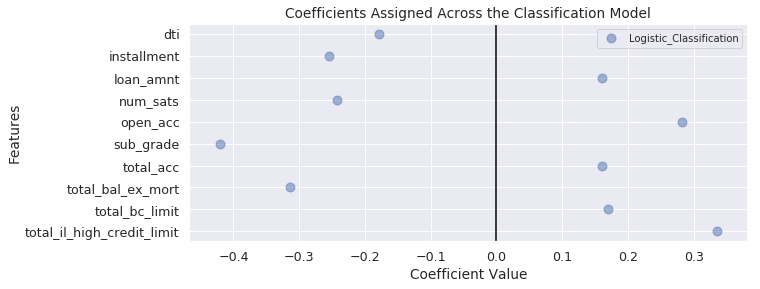

In [354]:
models = dict(Logistic_Classification=log_cls,)
coefs = plot_coefficients(X_train_scaled, models=models, thresh=(0.15,2), title='Classification Model')

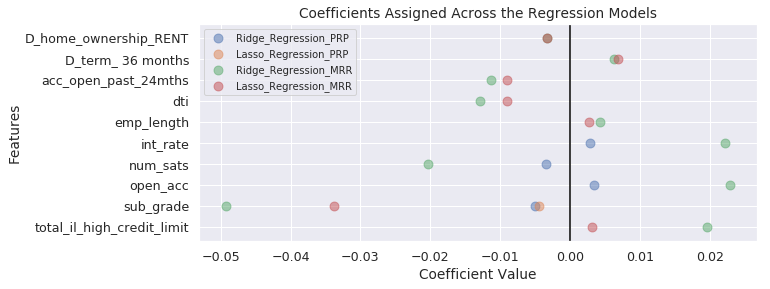

In [355]:
models = dict(Ridge_Regression_PRP=ridge_reg_PRP,
              Lasso_Regression_PRP=lasso_reg_PRP,
              Ridge_Regression_MRR=ridge_reg_MRR,
              Lasso_Regression_MRR=lasso_reg_MRR)
coefs = plot_coefficients(X_train_scaled, models=models, thresh=(0.0025,3), title='Regression Models')

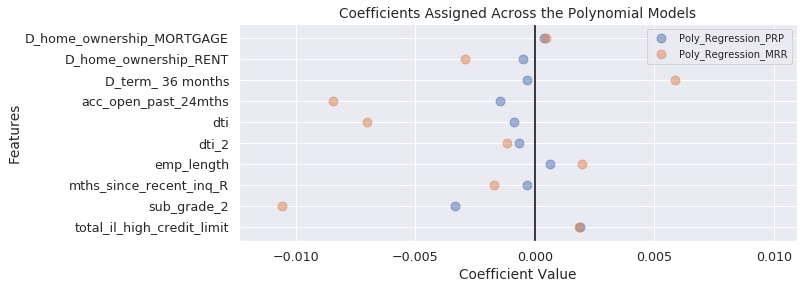

In [356]:
models = dict(
          Poly_Regression_PRP=lasso_reg2_PRP,
          Poly_Regression_MRR=lasso_reg2_MRR)
coefs2 = plot_coefficients(X_train_scaled_2, models=models, thresh=(0.0003,3), title='Polynomial Models')

## 2. Key Variables Driving Investment Decisions

The modeling has revealed the most likely key variables that should power the investment decisions: those which have significant coefficients across the distinct classification and regression models. These form the subset for our investment strategy formulation. This will aid interpretation and understanding for the investor at the loss of minimal investment efficacy. 

**Top 10 Key Variables**:

In [317]:
key_variables = coefs['coefs'].sort_values().reset_index(drop=True)
key_variables.name = 'key_variables'
print(key_variables)

0         D_home_ownership_RENT
1             D_term_ 36 months
2          acc_open_past_24mths
3                           dti
4                    emp_length
5                      int_rate
6                      num_sats
7                      open_acc
8                     sub_grade
9    total_il_high_credit_limit
Name: key_variables, dtype: object


## 3. Investment Strategy

With the key variables established, we now perform decision tree and random forest analysis on this key subset to establish the investment strategy.

## 4. Predictive Quality of Model

**Expected Risk and Return**